# **Importando módulos necessários**

In [ ]:
import os
import pandas as pd
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings("ignore")
set_seed(42)

print ('bibliotecas carregadas')

bibliotecas carregadas


# **Acesso aos dados via Kaggle + Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mehradaria/leukemia")

print("Diretório dos dados:", path)

100%|██████████| 110M/110M [00:00<00:00, 126MB/s]

Extracting files...


Diretório dos dados: /root/.cache/kagglehub/datasets/mehradaria/leukemia/versions/1


#### **Lendo dados (fotos) e carregando-os num dataframe**

In [ ]:
# Generate data paths with labels
data_dir = path +'/Original'
filepaths = []
labels = []

# Crie um dicionário de mapeamento para traduzir os rótulos
label_map = {
    'Early': 'Inicial',
    'PreB': 'Pré B',
    'ProB': 'Pró B',
    'Benign': 'Benigno'
}

for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)
    # Verifica se é um diretório antes de listar os arquivos
    if os.path.isdir(foldpath):
        for file in os.listdir(foldpath):
            fpath = os.path.join(foldpath, file)
            # Use os.path.relpath to create relative path from data_dir,
            # ensuring correctness if notebook is not run from the root directory
            fpath = os.path.relpath(fpath, data_dir)
            filepaths.append(fpath)
            # Aplica o mapeamento para traduzir o rótulo
            original_label = fold
            translated_label = label_map.get(original_label, original_label) # Usa o original se não encontrar no mapa
            labels.append(translated_label)


# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
#path

In [ ]:
df

print('dataframe carregado')

dataframe carregado


####**Checando distribuição de tipos de célula rotulados**

Text(0, 0.5, 'Tipos de célula')

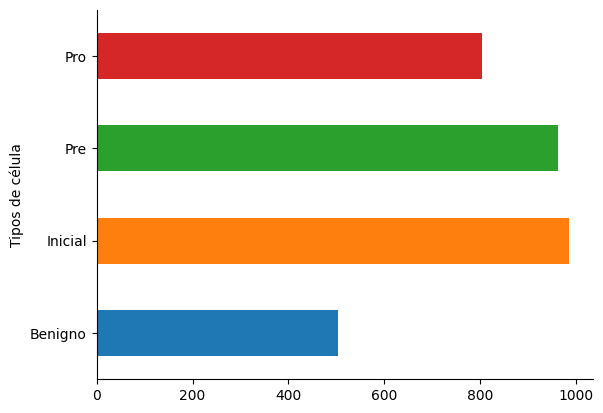

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('tab10'))
plt.gca().spines[['top', 'right',]].set_visible(False)
# Adiciona o rótulo ao eixo y
plt.ylabel('Tipos de célula')

In [ ]:
dls = ImageDataLoaders.from_df(df,
                                fn_col=0, # diretorio
                                label_col=1, # labels
                                valid_pct=0.2,
                                folder=data_dir, # Mudar pro diretorio de dados (data_dir)
                                item_tfms=Resize(224))

####**Criando exibição aleatória de diferentes fotos/dados e seus labels/rótulos**

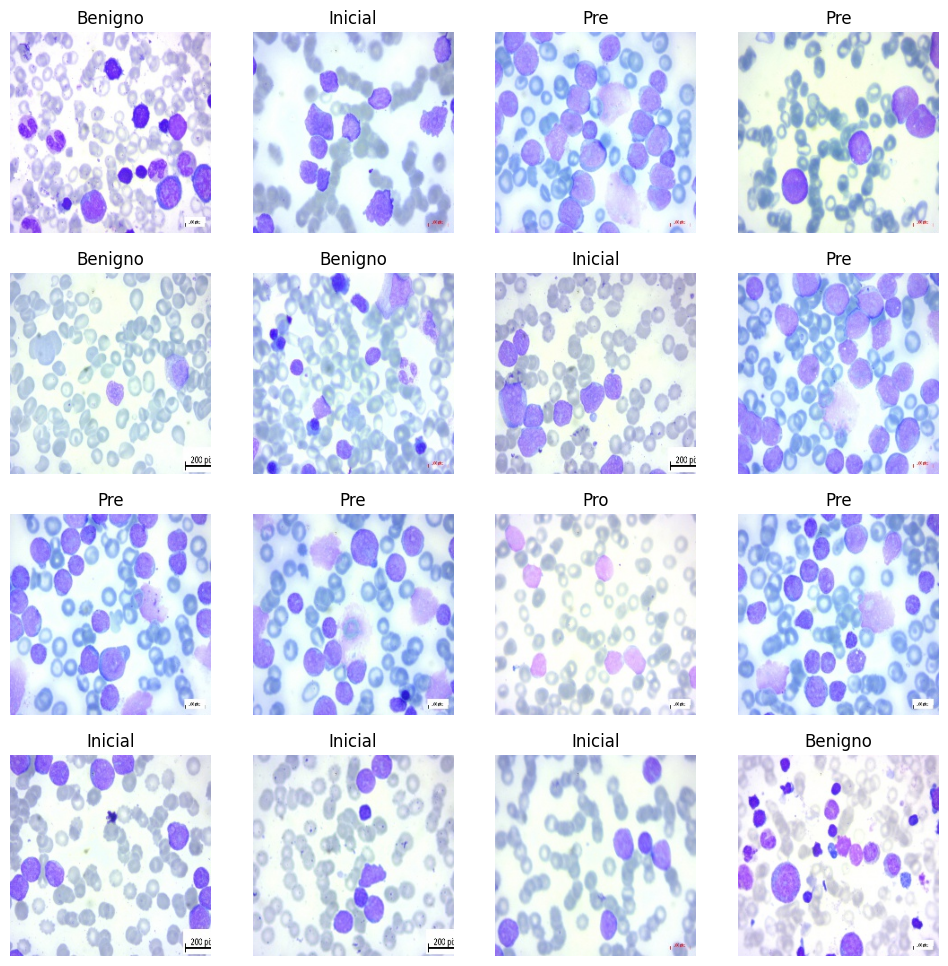

In [ ]:
dls.show_batch(max_n=16)

# **Estrutura do modelo**

In [ ]:
#seleção do efficientnet B3, metricas
learn = vision_learner(
    dls,
    'efficientnet_b3',
    metrics=[accuracy, error_rate],
    path='.').to_fp16()
learn.summary()

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 112 x 112 
Conv2d                                    1080       False     
Identity                                                       
SiLU                                                           
Conv2d                                    360        False     
Identity                                                       
SiLU                                                           
Identity                                                       
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                             

####**Gráfico da curva de aprendizado do modelo**

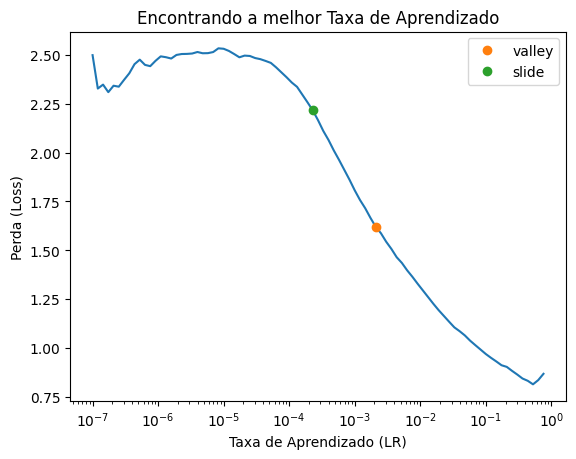

In [ ]:
#learn.lr_find(suggest_funcs=(valley, slide))
learn.lr_find(suggest_funcs=(valley, slide))

# Personalizando o gráfico em português
import matplotlib.pyplot as plt
plt.xlabel("Taxa de Aprendizado (LR)")
plt.ylabel("Perda (Loss)")
plt.title("Encontrando a melhor Taxa de Aprendizado")
plt.show()

## **Treinamento**

In [ ]:
learn.fit_one_cycle(20)

#selecionadas 20 épocas

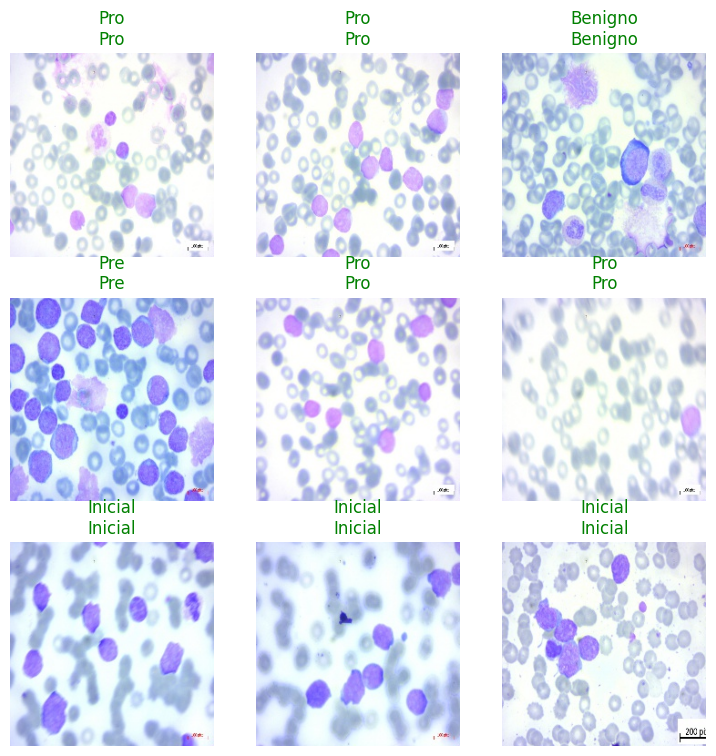

In [ ]:
learn.show_results()
#resultados aleatorios de previsoes

In [ ]:
# Salvando modelo no diretorio
learn.save('/kaggle/model')

Path('/kaggle/model.pth')

In [ ]:
#construindo um objeto de Interpretação de Classificação do modelo aprendido
#isso nos mostra onde o modelo fez as piores previsões:
interp = ClassificationInterpretation.from_learner(learn)

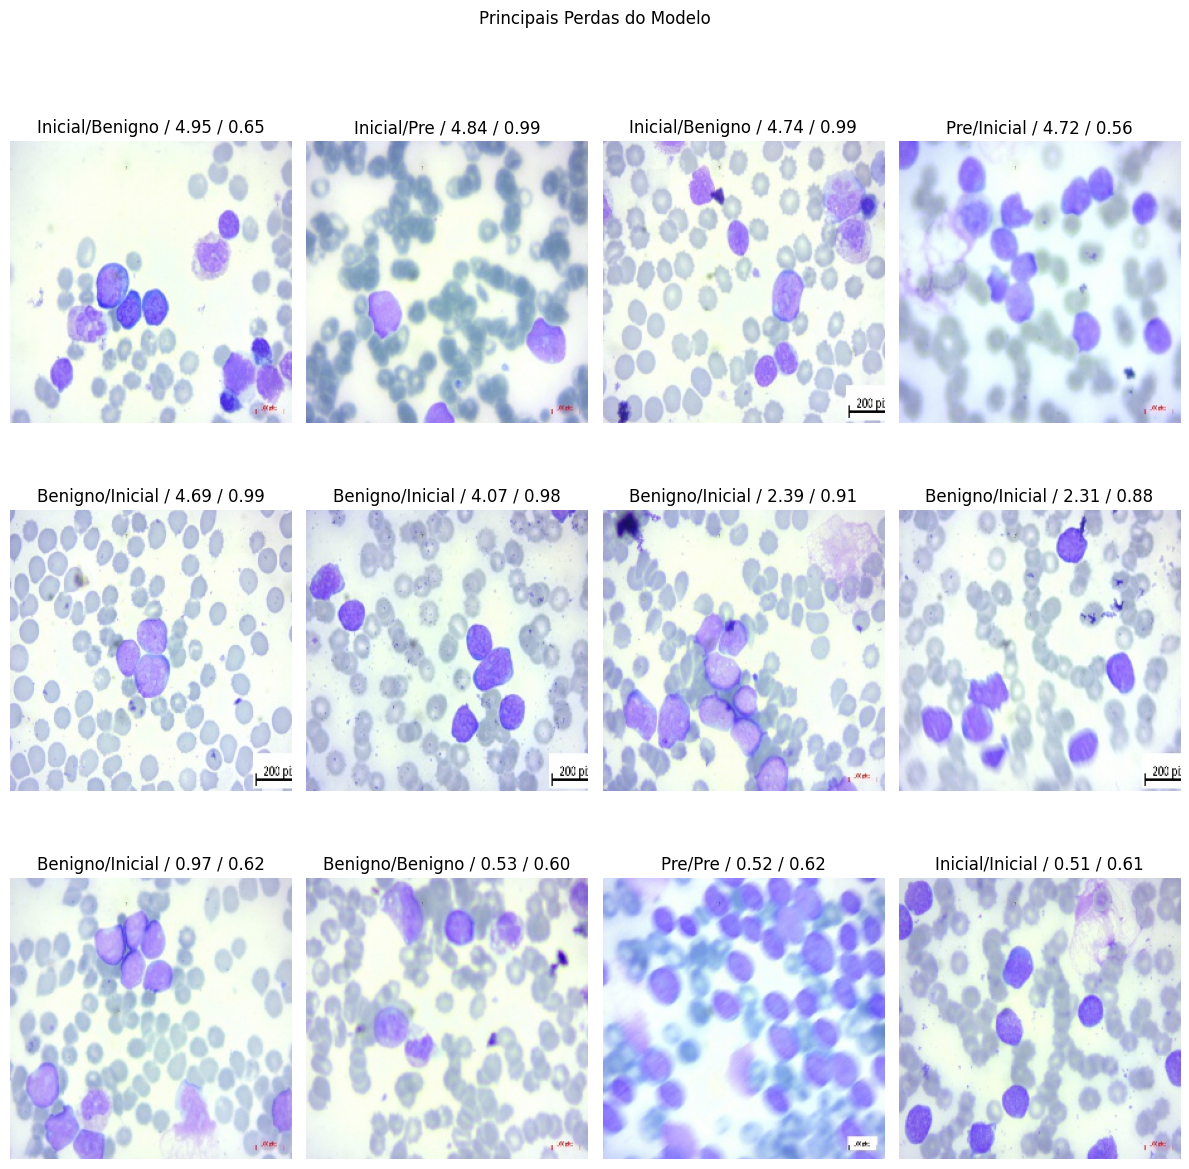

In [ ]:
#plotando as primeiras n=12 classes onde o classificador foi menos preciso
interp.plot_top_losses(12, figsize=(12,12))

# Traduzir os rótulos e o título para português
fig = plt.gcf() # Pega a figura atual
fig.suptitle('Principais Perdas do Modelo', y=1.02) # Título principal da figura

# Traduzir os títulos dos subplots (cada imagem)
for ax in fig.axes:
    title = ax.get_title()
    # Exemplo de tradução: "Prediction: Pro/Actual: Pro/Loss: 0.0000/Prob: 1.0000"
    # Queremos traduzir "Prediction", "Actual", "Loss", "Prob"
    translated_title = title.replace("Prediction:", "Previsão:").replace("Actual:", "Real:").replace("Loss:", "Perda:").replace("Prob:", "Probabilidade:")
    ax.set_title(translated_title)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [ ]:
#interp.plot_confusion_matrix(figsize=(6,6), dpi=60,title="Matriz de confusão")
#matriz de confusao FASTAI

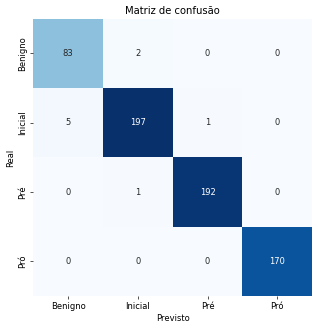

In [ ]:
#matriz de confusao MATPLOTLIB

# Obtenha a matriz de confusão
cm = interp.confusion_matrix()

# Defina os rótulos em português
labels_portugues = ['Benigno', 'Inicial', 'Pré', 'Pró'] # Adapte conforme seus rótulos originais

# Crie o plot com seaborn
plt.figure(figsize=(6, 6), dpi=60)
sns.heatmap(cm, cbar=False,annot=True, fmt='d', cmap='Blues', xticklabels=labels_portugues, yticklabels=labels_portugues)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão')
plt.show()

##**Exibição de resultados**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Matriz de confusão extraída da imagem
conf_matrix = np.array([[83, 2, 0, 0],
                        [5, 197, 1, 0],
                        [0, 1, 192, 1],
                        [0, 0, 1, 170]])

# Criando listas de valores reais e previstos
y_true = []
y_pred = []
labels = ["Benigno", "Inicial", "Pré B", "Pró B"]

for i in range(4):  # Para cada classe
    for j in range(4):  # Para cada previsão
        y_true.extend([i] * conf_matrix[i, j])  # Repete o valor real
        y_pred.extend([j] * conf_matrix[i, j])  # Repete a previsão

# Cálculo das métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Exibir resultados
print(f"Acurácia: {accuracy:.4f}")
for i, label in enumerate(labels):
    print(f"{label}: Precisão={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1[i]:.4f}")


Acurácia: 0.9832
Benigno: Precisão=0.9432, Recall=0.9765, F1-Score=0.9595
Inicial: Precisão=0.9850, Recall=0.9704, F1-Score=0.9777
Pré B: Precisão=0.9897, Recall=0.9897, F1-Score=0.9897
Pró B: Precisão=0.9942, Recall=0.9942, F1-Score=0.9942


####**Acurácia de teste**
(para comparação e indicação de possivel overfitting)

In [ ]:
test_accuracy = learn.validate()[1]  # Retorna [loss, accuracy]
print(f"Acurácia no Teste: {test_accuracy:.4f}")

Acurácia no Teste: 0.9862


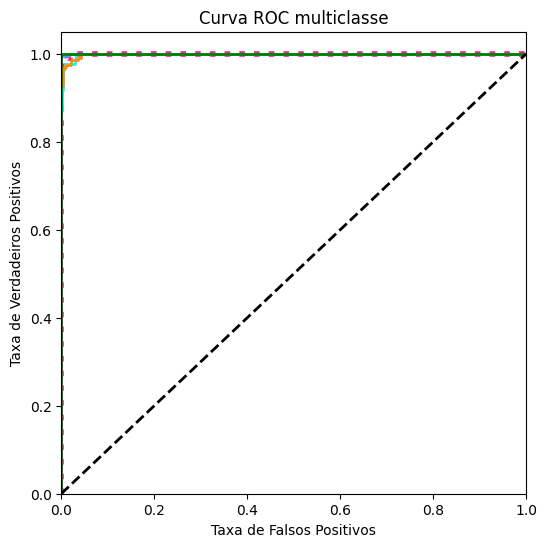

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Obtenha as previsões e os rótulos reais do conjunto de validação
preds, targets = learn.get_preds(ds_idx=1) # ds_idx=1 para o conjunto de validação

# Converta os rótulos reais para one-hot encoding
n_classes = len(dls.vocab)
targets_one_hot = label_binarize(targets, classes=np.arange(n_classes))

# Calcule a Curva ROC e a Área sob a Curva (AUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Opcional: Calcular a Curva ROC e AUC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(targets_one_hot.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a Curva ROC para cada classe e a micro-average
plt.figure(figsize=(6, 6))
lw = 2

plt.plot(fpr["micro"], tpr["micro"],
         label='Curva ROC Micro-average (area = {0:0.2f})' # Legend label in Portuguese
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green'] # Adapte as cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    # Legend label in Portuguese, using the class name from dls.vocab
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (area = {1:0.2f})'
             ''.format(dls.vocab[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos') # Axis label in Portuguese
plt.ylabel('Taxa de Verdadeiros Positivos') # Axis label in Portuguese
plt.title('Curva ROC multiclasse') # Title in Portuguese

plt.show()

Text(0.5, 1.0, 'Curva ROC Multiclasse (Zoom)')

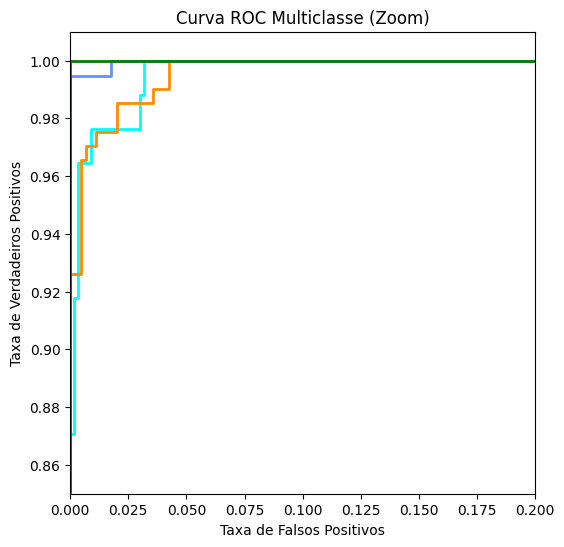

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Obtenha as previsões e os rótulos reais do conjunto de validação
preds, targets = learn.get_preds(ds_idx=1) # ds_idx=1 para o conjunto de validação

# Converta os rótulos reais para one-hot encoding
n_classes = len(dls.vocab)
targets_one_hot = label_binarize(targets, classes=np.arange(n_classes))

# Calcule a Curva ROC e a Área sob a Curva (AUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Opcional: Calcular a Curva ROC e AUC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(targets_one_hot.ravel(), preds.ravel())
# Corrigido: usar tpr["micro"] para o cálculo da AUC micro-average
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a Curva ROC com Zoom
plt.figure(figsize=(6, 6)) # Mantém um bom tamanho de figura
lw = 2

# Plotar a linha diagonal de referência
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green'] # Adapte as cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    # Legend label in Portuguese, using the class name from dls.vocab
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (área = {1:0.2f})' # Label in Portuguese
             ''.format(dls.vocab[i], roc_auc[i]))

# **AJUSTE ESTES LIMITES PARA DAR ZOOM**
# Experimente valores como 0.1, 0.2, etc. para X
# Experimente valores como 0.7, 0.8, 0.9, etc. para Y
zoom_xlim_max = 0.2 # Limite superior do eixo X (FPR)
zoom_ylim_min = 0.85 # Limite inferior do eixo Y (TPR)

plt.xlim([0.0, zoom_xlim_max])
plt.ylim([zoom_ylim_min, 1.01]) # Mantém o espaço extra no topo

plt.xlabel('Taxa de Falsos Positivos') # Axis label already in Portuguese
plt.ylabel('Taxa de Verdadeiros Positivos') # Axis label already in Portuguese
plt.title('Curva ROC Multiclasse (Zoom)') # Title already in Portuguese

# Removed plt.show() as the user wants to run this code block in a notebook cell

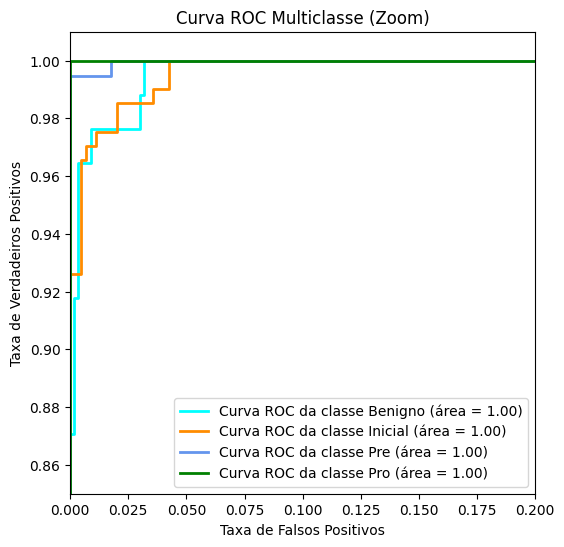

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Obtenha as previsões e os rótulos reais do conjunto de validação
preds, targets = learn.get_preds(ds_idx=1) # ds_idx=1 para o conjunto de validação

# Converta os rótulos reais para one-hot encoding
n_classes = len(dls.vocab)
targets_one_hot = label_binarize(targets, classes=np.arange(n_classes))

# Calcule a Curva ROC e a Área sob a Curva (AUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Opcional: Calcular a Curva ROC e AUC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(targets_one_hot.ravel(), preds.ravel())
# Corrigido: usar tpr["micro"] para o cálculo da AUC micro-average
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a Curva ROC com Zoom
plt.figure(figsize=(6, 6)) # Mantém um bom tamanho de figura
lw = 2

# Plotar a linha diagonal de referência
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green'] # Adapte as cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    # Legend label in Portuguese, using the class name from dls.vocab
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (área = {1:0.2f})' # Label in Portuguese
             ''.format(dls.vocab[i], roc_auc[i]))

# **AJUSTE ESTES LIMITES PARA DAR ZOOM**
# Experimente valores como 0.1, 0.2, etc. para X
# Experimente valores como 0.7, 0.8, 0.9, etc. para Y
zoom_xlim_max = 0.2 # Limite superior do eixo X (FPR)
zoom_ylim_min = 0.85 # Limite inferior do eixo Y (TPR)

plt.xlim([0.0, zoom_xlim_max])
plt.ylim([zoom_ylim_min, 1.01]) # Mantém o espaço extra no topo

plt.xlabel('Taxa de Falsos Positivos') # Axis label already in Portuguese
plt.ylabel('Taxa de Verdadeiros Positivos') # Axis label already in Portuguese
plt.title('Curva ROC Multiclasse (Zoom)') # Title already in Portuguese
plt.legend(loc="lower right")
# Removed plt.show() as the user wants to run this code block in a notebook cell

In [ ]:
import numpy as np

# Obtenha a matriz de confusão
cm = interp.confusion_matrix()

# Defina os rótulos das classes
labels = dls.vocab # Usando os rótulos do dls para consistência

print("Métricas de Sensibilidade e Especificidade por Classe:")

for i in range(len(labels)):
    # Calcula TP, FP, FN, TN para a classe i
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP

    # Calcula Sensibilidade e Especificidade
    sensibilidade = TP / (TP + FN) if (TP + FN) > 0 else 0
    especificidade = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"Classe '{labels[i]}':")
    print(f"  Sensibilidade (Recall): {sensibilidade:.4f}")
    print(f"  Especificidade: {especificidade:.4f}")

Métricas de Sensibilidade e Especificidade por Classe:
Classe 'Benigno':
  Sensibilidade (Recall): 0.9765
  Especificidade: 0.9912
Classe 'Inicial':
  Sensibilidade (Recall): 0.9704
  Especificidade: 0.9933
Classe 'Pre':
  Sensibilidade (Recall): 0.9948
  Especificidade: 0.9978
Classe 'Pro':
  Sensibilidade (Recall): 1.0000
  Especificidade: 1.0000


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Obtenha a matriz de confusão
cm = interp.confusion_matrix()

# Defina os rótulos das classes
labels = dls.vocab

# Crie listas para armazenar os resultados
class_names = []
sensitivities = []
specificities = []

for i in range(len(labels)):
    # Calcula TP, FP, FN, TN para a classe i
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP

    # Calcula Sensibilidade e Especificidade
    sensibilidade = TP / (TP + FN) if (TP + FN) > 0 else 0
    especificidade = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Adicione os resultados às listas
    class_names.append(labels[i])
    sensitivities.append(sensibilidade)
    specificities.append(especificidade)

# Crie um DataFrame pandas com os resultados
df_metrics = pd.DataFrame({
    'Classe': class_names,
    'Sensibilidade (Recall)': sensitivities,
    'Especificidade': specificities
})

# Formate as colunas de métricas para melhor visualização
df_metrics['Sensibilidade (Recall)'] = df_metrics['Sensibilidade (Recall)'].apply(lambda x: f'{x:.4f}')
df_metrics['Especificidade'] = df_metrics['Especificidade'].apply(lambda x: f'{x:.4f}')


print("Tabela de Métricas de Sensibilidade e Especificidade por Classe:")
# Exiba o DataFrame
display(df_metrics)

Tabela de Métricas de Sensibilidade e Especificidade por Classe:


Classe Sensibilidade (Recall) Especificidade
0  Benign                 0.9765         0.9912
1   Early                 0.9704         0.9933
2     Pre                 0.9948         0.9978
3     Pro                 1.0000         1.0000

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display # Para exibir DataFrames ou outros objetos

# Obtenha as previsões e os rótulos reais do conjunto de validação
# ds_idx=1 se refere ao conjunto de validação na estrutura de dados fastai
preds, targets = learn.get_preds(ds_idx=1)

# As previsões (preds) são probabilidades para cada classe. Para calcular
# métricas que precisam de classes preditas (como accuracy, precision, recall, f1),
# precisamos converter as probabilidades para a classe com maior probabilidade.
predicted_classes = torch.argmax(preds, dim=1)

# Converta os tensores PyTorch para arrays numpy para usar com scikit-learn
targets_np = targets.cpu().numpy()
predicted_classes_np = predicted_classes.cpu().numpy()

# **Métricas Gerais**

# Acurácia Geral
accuracy_general = accuracy_score(targets_np, predicted_classes_np)

# Precisão Média (podemos usar diferentes tipos de média: 'micro', 'macro', 'weighted')
# 'macro' calcula a métrica para cada classe e retorna a média não ponderada.
# 'weighted' calcula a métrica para cada classe e retorna a média ponderada pelo número de instâncias de cada classe.
# 'micro' calcula métricas globais contando o total de verdadeiros positivos, falsos negativos e falsos positivos.

precision_macro = precision_score(targets_np, predicted_classes_np, average='macro')
recall_macro = recall_score(targets_np, predicted_classes_np, average='macro') # Recall médio = Sensibilidade média
f1_macro = f1_score(targets_np, predicted_classes_np, average='macro')

precision_weighted = precision_score(targets_np, predicted_classes_np, average='weighted')
recall_weighted = recall_score(targets_np, predicted_classes_np, average='weighted')
f1_weighted = f1_score(targets_np, predicted_classes_np, average='weighted')

# Exibir resultados das métricas gerais

print("Métricas Gerais do Modelo (Conjunto de Validação):")
print(f"Acurácia: {accuracy_general:.4f}")
print(f"Precisão Média (Macro): {precision_macro:.4f}")
print(f"Recall Médio (Macro) / Sensibilidade Média: {recall_macro:.4f}")
print(f"F1-Score Médio (Macro): {f1_macro:.4f}")
print("-" * 30)
print(f"Precisão Média (Weighted): {precision_weighted:.4f}")
print(f"Recall Médio (Weighted): {recall_weighted:.4f}")
print(f"F1-Score Médio (Weighted): {f1_weighted:.4f}")

# Opcional: Criar um DataFrame para exibir de forma tabular
import pandas as pd

metrics_summary = {
    'Métrica': ['Acurácia', 'Precisão Média (Macro)', 'Recall Médio (Macro)', 'F1-Score Médio (Macro)',
                'Precisão Média (Weighted)', 'Recall Médio (Weighted)', 'F1-Score Médio (Weighted)'],
    'Valor': [accuracy_general, precision_macro, recall_macro, f1_macro,
              precision_weighted, recall_weighted, f1_weighted]
}

df_general_metrics = pd.DataFrame(metrics_summary)
df_general_metrics['Valor'] = df_general_metrics['Valor'].apply(lambda x: f'{x:.4f}')

print("\nTabela de Métricas Gerais:")
display(df_general_metrics)

Métricas Gerais do Modelo (Conjunto de Validação):
Acurácia: 0.9862
Precisão Média (Macro): 0.9808
Recall Médio (Macro) / Sensibilidade Média: 0.9854
F1-Score Médio (Macro): 0.9830
------------------------------
Precisão Média (Weighted): 0.9864
Recall Médio (Weighted): 0.9862
F1-Score Médio (Weighted): 0.9862

Tabela de Métricas Gerais:


Métrica   Valor
0                   Acurácia  0.9862
1     Precisão Média (Macro)  0.9808
2       Recall Médio (Macro)  0.9854
3     F1-Score Médio (Macro)  0.9830
4  Precisão Média (Weighted)  0.9864
5    Recall Médio (Weighted)  0.9862
6  F1-Score Médio (Weighted)  0.9862

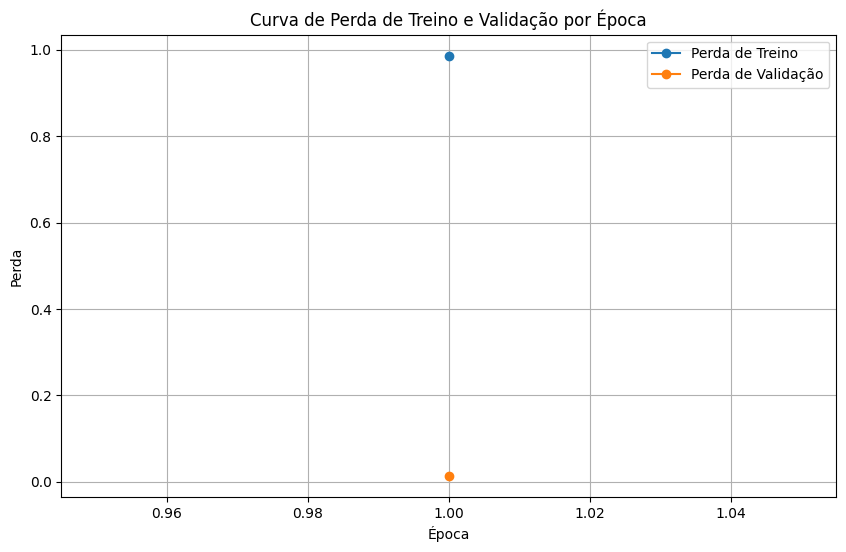

In [ ]:
# Certifique-se de ter executado learn.fit_one_cycle(20) antes deste código

import matplotlib.pyplot as plt

# Obtenha o histórico de treinamento e validação do recorder
# O recorder.values contém uma lista de listas, onde cada lista interna
# corresponde a uma época e contém [epoch, train_loss, valid_loss, metric1, metric2, ...]
history_values = learn.recorder.values

# Extraia as perdas de treino e validação
train_losses = [v[1] for v in history_values]
valid_losses = [v[2] for v in history_values]
epochs = range(1, len(history_values) + 1)

# Crie o gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Perda de Treino', marker='o')
plt.plot(epochs, valid_losses, label='Perda de Validação', marker='o')

plt.title('Curva de Perda de Treino e Validação por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()

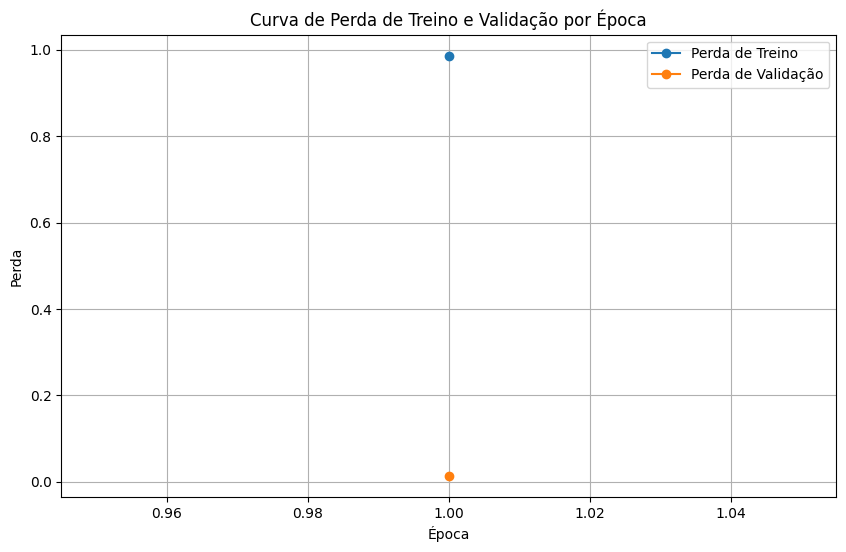

In [ ]:
# Certifique-se de que o treinamento já foi executado: learn.fit_one_cycle(20)

import matplotlib.pyplot as plt

# Obtenha o histórico de treinamento e validação do recorder
# O recorder.values contém uma lista de listas, onde cada lista interna
# corresponde a uma época e contém [epoch, train_loss, valid_loss, metric1, metric2, ...]
history_values = learn.recorder.values

# Extraia as perdas de treino e validação
train_losses = [v[1] for v in history_values]
valid_losses = [v[2] for v in history_values]
epochs = range(1, len(history_values) + 1)

# Crie o gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Perda de Treino', marker='o')
plt.plot(epochs, valid_losses, label='Perda de Validação', marker='o')

plt.title('Curva de Perda de Treino e Validação por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()

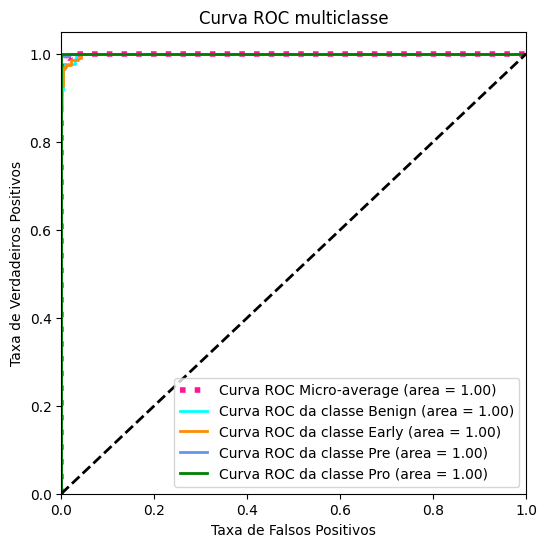

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Obtenha as previsões e os rótulos reais do conjunto de validação
# ds_idx=1 para o conjunto de validação na estrutura de dados fastai
preds, targets = learn.get_preds(ds_idx=1)

# Converta os rótulos reais para one-hot encoding
n_classes = len(dls.vocab)
targets_one_hot = label_binarize(targets, classes=np.arange(n_classes))

# Calcule a Curva ROC e a Área sob a Curva (AUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Opcional: Calcular a Curva ROC e AUC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(targets_one_hot.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a Curva ROC para cada classe e a micro-average
plt.figure(figsize=(6, 6))
lw = 2

plt.plot(fpr["micro"], tpr["micro"],
         label='Curva ROC Micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green'] # Adapte as cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (area = {1:0.2f})'
             ''.format(dls.vocab[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC multiclasse')
plt.legend(loc="lower right")
plt.show()

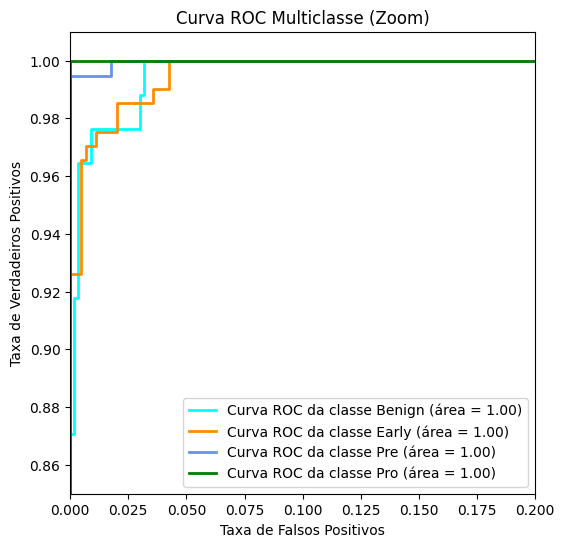

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Obtenha as previsões e os rótulos reais do conjunto de validação
# ds_idx=1 para o conjunto de validação na estrutura de dados fastai
preds, targets = learn.get_preds(ds_idx=1)

# Converta os rótulos reais para one-hot encoding
n_classes = len(dls.vocab)
targets_one_hot = label_binarize(targets, classes=np.arange(n_classes))

# Calcule a Curva ROC e a Área sob a Curva (AUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Opcional: Calcular a Curva ROC e AUC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(targets_one_hot.ravel(), preds.ravel())
# Corrigido: usar tpr["micro"] para o cálculo da AUC micro-average
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a Curva ROC com Zoom
plt.figure(figsize=(6, 6)) # Mantém um bom tamanho de figura
lw = 2

# Plotar a linha diagonal de referência
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green'] # Adapte as cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    # Legend label in Portuguese, using the class name from dls.vocab
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (área = {1:0.2f})' # Label in Portuguese
             ''.format(dls.vocab[i], roc_auc[i]))

# **AJUSTE ESTES LIMITES PARA DAR ZOOM**
# Experimente valores como 0.1, 0.2, etc. para X
# Experimente valores como 0.7, 0.8, 0.9, etc. para Y
zoom_xlim_max = 0.2 # Limite superior do eixo X (FPR)
zoom_ylim_min = 0.85 # Limite inferior do eixo Y (TPR)

plt.xlim([0.0, zoom_xlim_max])
plt.ylim([zoom_ylim_min, 1.01]) # Mantém o espaço extra no topo

plt.xlabel('Taxa de Falsos Positivos') # Axis label already in Portuguese
plt.ylabel('Taxa de Verdadeiros Positivos') # Axis label already in Portuguese
plt.title('Curva ROC Multiclasse (Zoom)') # Title already in Portuguese
plt.legend(loc="lower right")
# Removed plt.show() as the user wants to run this code block in a notebook cell

In [ ]:
total_images = len(df)
train_images = len(dls.train.dataset)
valid_images = len(dls.valid.dataset)

train_percentage = (train_images / total_images) * 100
valid_percentage = (valid_images / total_images) * 100

print(f"Total de imagens no dataset original: {total_images}")
print(f"Número de imagens no conjunto de treino: {train_images} ({train_percentage:.2f}%)")
print(f"Número de imagens no conjunto de validação (teste): {valid_images} ({valid_percentage:.2f}%)")

Total de imagens no dataset original: 3256
Número de imagens no conjunto de treino: 2605 (80.01%)
Número de imagens no conjunto de validação (teste): 651 (19.99%)


Sim, um split de 80/20 (80% para treino e 20% para validação/teste) é uma divisão bem comum e geralmente considerada boa na área de machine learning, especialmente para datasets de tamanho razoável como o seu.

É um bom equilíbrio que permite que o modelo veja uma quantidade significativa de dados durante o treinamento (80%) para aprender os padrões, enquanto ainda reserva uma porção razoável (20%) para avaliar o desempenho em dados que o modelo não viu durante o treinamento. Isso ajuda a ter uma estimativa mais confiável de quão bem o modelo generalizará para novos dados.


In [ ]:
import sys
import platform
import os

print("Informações do Python:")
print(f"Versão do Python: {sys.version}")
print(f"Implementação do Python: {platform.python_implementation()}")
print(f"Compilador: {platform.python_compiler()}")

print("\nInformações do Sistema:")
print(f"Sistema Operacional: {platform.system()}")
print(f"Nome do Nó: {platform.node()}")
print(f"Release do OS: {platform.release()}")
print(f"Versão do OS: {platform.version()}")
print(f"Arquitetura: {platform.machine()}")
print(f"Processador: {platform.processor()}")

print("\nInformações do Ambiente (se aplicável):")
if 'COLAB_GPU' in os.environ:
    print("Ambiente: Google Colab")
    print(f"Tipo de GPU no Colab: {os.environ['COLAB_GPU']}")
elif 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Ambiente: Kaggle Kernel")
    print(f"Tipo de Kernel no Kaggle: {os.environ['KAGGLE_KERNEL_RUN_TYPE']}")
else:
    print("Ambiente: Desconhecido ou local")

# Exemplo adicional: verificar a versão de uma biblioteca específica
try:
    import fastai
    print(f"\nVersão da fastai: {fastai.__version__}")
except ImportError:
    print("\nBiblioteca fastai não encontrada.")

try:
    import torch
    print(f"Versão do PyTorch: {torch.__version__}")
except ImportError:
    print("Biblioteca PyTorch não encontrada.")

Informações do Python:
Versão do Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Implementação do Python: CPython
Compilador: GCC 11.4.0

Informações do Sistema:
Sistema Operacional: Linux
Nome do Nó: b1742026ed6f
Release do OS: 6.1.123+
Versão do OS: #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
Arquitetura: x86_64
Processador: x86_64

Informações do Ambiente (se aplicável):
Ambiente: Google Colab
Tipo de GPU no Colab: 1

Versão da fastai: 2.7.19
Versão do PyTorch: 2.6.0+cu124


Informações do Python:
Versão do Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Implementação do Python: CPython
Compilador: GCC 11.4.0

Informações do Sistema:
Sistema Operacional: Linux
Nome do Nó: afb6fa27ed67
Release do OS: 6.1.123+
Versão do OS: #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
Arquitetura: x86_64
Processador: x86_64

Informações do Ambiente (se aplicável):
Ambiente: Google Colab
Tipo de GPU no Colab: 1

Versão da fastai: 2.7.19
Versão do PyTorch: 2.6.0+cu124

In [ ]:
# Informações da CPU
!lscpu

# Informações da Memória RAM
!free -h

# Informações da GPU (se disponível)
!nvidia-smi

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.26
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dno
                          wprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase
                           tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm r
                          dseed adx smap xsaveopt arat md_clear arch_capabilitie
                          s
Virtualization features:  
  Hypervisor vendor:      KVM
  Virtualization type:    full
Caches (sum of all):      
  L1d:                    32 KiB (1 instance)
  L1i:                    32 KiB (1 instance)
  L2:                     256 KiB (1 instance)
  L3:                     55 MiB (1 instance)
NUMA:                     
  NUMA node(s):           1
  NUMA node0 CPU(s):      0,1
Vulnerabilities:          
  Gather data sampling:   Not affected
  Itlb multihit:          Not affected
  L1tf:                   Mitigation; PTE Inversion
  Mds:                    Vulnerable; SMT Host state unknown
  Meltdown:               Vulnerable
  Mmio stale data:        Vulnerable
  Reg file data sampling: Not affected
  Retbleed:               Vulnerable
  Spec rstack overflow:   Not affected
  Spec store bypass:      Vulnerable
  Spectre v1:             Vulnerable: __user pointer sanitization and usercopy b
                          arriers only; no swapgs barriers
  Spectre v2:             Vulnerable; IBPB: disabled; STIBP: disabled; PBRSB-eIB
                          RS: Not affected; BHI: Vulnerable
  Srbds:                  Not affected
  Tsx async abort:        Vulnerable
               total        used        free      shared  buff/cache   available
Mem:            12Gi       3.0Gi       4.7Gi        16Mi       5.0Gi       9.4Gi
Swap:             0B          0B          0B
Tue Jun 24 21:03:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             28W /   70W |    5992MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
+-----------------------------------------------------------------------------------------+


In [ ]:
import pandas as pd
import numpy as np

# Obtenha os rótulos das classes do dls.vocab
labels = dls.vocab

# Crie um dicionário para armazenar os dados da tabela
auc_data = {'Classe': [], 'AUC': []}

# Adicione os valores de AUC por classe
for i, label in enumerate(labels):
    auc_data['Classe'].append(label)
    auc_data['AUC'].append(roc_auc[i])

# Adicione o valor de AUC Micro-average
auc_data['Classe'].append('Micro-average')
auc_data['AUC'].append(roc_auc['micro'])

# Crie o DataFrame
df_auc = pd.DataFrame(auc_data)

# Formate a coluna AUC para ter 4 casas decimais
df_auc['AUC'] = df_auc['AUC'].apply(lambda x: f'{x:.4f}')

# Gere a tabela LaTeX
latex_table = df_auc.to_latex(index=False, caption="Valores de AUC por Classe e Micro-average", label="tab:auc_values")

print("Tabela LaTeX dos Valores de AUC:")
print(latex_table)

Tabela LaTeX dos Valores de AUC:
\begin{table}
\caption{Valores de AUC por Classe e Micro-average}
\label{tab:auc_values}
\begin{tabular}{ll}
\toprule
Classe & AUC \\
\midrule
Benign & 0.9997 \\
Early & 0.9999 \\
Pre & 0.9999 \\
Pro & 1.0000 \\
Micro-average & 0.9999 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from IPython.display import display

# Obter o DataLoader do conjunto de treino
train_dl = dls.train

# Obter previsões e rótulos manualmente iterando sobre o DataLoader
train_preds = []
train_targets = []

# Colocar o modelo em modo de avaliação
learn.model.eval()

with torch.no_grad(): # Desativar cálculo de gradientes para inferência
    for xb, yb in train_dl:
        # Mover dados para o mesmo dispositivo do modelo (GPU, se disponível)
        # Correção: Usar .to() para mover os tensores para o dispositivo
        xb = xb.to(learn.dls.device)
        yb = yb.to(learn.dls.device)

        # Obter previsões (saídas do modelo)
        output = learn.model(xb)

        # Aplicar a função de ativação (softmax, por exemplo, se a última camada não for softmax)
        if hasattr(learn.loss_func, 'activation'):
             probas = learn.loss_func.activation(output)
        else:
             probas = torch.softmax(output, dim=1) # Aplicar softmax manualmente


        train_preds.append(probas.cpu()) # Mover para CPU e adicionar à lista
        train_targets.append(yb.cpu())   # Mover para CPU e adicionar à lista

# Concatenar os tensores das listas
train_preds = torch.cat(train_preds)
train_targets = torch.cat(train_targets)


# Converter os rótulos reais de treino para one-hot encoding
n_classes = len(dls.vocab)
train_targets_one_hot = label_binarize(train_targets.numpy(), classes=np.arange(n_classes))

# Calcule a Curva ROC e a Área sob a Curva (AUC) para cada classe no treino
train_fpr = dict()
train_tpr = dict()
train_roc_auc = dict()
for i in range(n_classes):
    train_fpr[i], train_tpr[i], _ = roc_curve(train_targets_one_hot[:, i], train_preds[:, i].numpy())
    train_roc_auc[i] = auc(train_fpr[i], train_tpr[i])

# Calcular a Curva ROC e AUC micro-average para treino
train_fpr["micro"], train_tpr["micro"], _ = roc_curve(train_targets_one_hot.ravel(), train_preds.ravel().numpy())
train_roc_auc["micro"] = auc(train_fpr["micro"], train_tpr["micro"])

# Calcular AUC macro-average para treino (média das AUCs por classe)
# Excluir 'micro' antes de calcular a média
train_macro_auc_values = [train_roc_auc[i] for i in range(n_classes)]
train_roc_auc["macro"] = np.mean(train_macro_auc_values)


print("AUCs do conjunto de Treino calculados.")

# --- Agora, combinar com os AUCs do conjunto de Validação (Teste) ---
# Assumindo que roc_auc (do conjunto de validação) já está disponível na memória.
# Se não estiver, você precisará executar a célula que calcula o AUC para o conjunto de validação primeiro.

# Crie um dicionário para armazenar os dados da tabela combinados
auc_data_combined = {'Classe': [], 'AUC Treino': [], 'AUC Validação': []}

# Adicione os valores de AUC por classe para treino e validação
for i, label in enumerate(dls.vocab):
    auc_data_combined['Classe'].append(label)
    auc_data_combined['AUC Treino'].append(train_roc_auc[i])
    # Assumindo que roc_auc[i] contém o AUC da classe i para validação
    auc_data_combined['AUC Validação'].append(roc_auc[i])

# Adicione os valores de AUC Micro-average para treino e validação
auc_data_combined['Classe'].append('Micro-average')
auc_data_combined['AUC Treino'].append(train_roc_auc['micro'])
auc_data_combined['AUC Validação'].append(roc_auc['micro'])

# Adicione os valores de AUC Macro-average para treino e validação
auc_data_combined['Classe'].append('Macro-average')
auc_data_combined['AUC Treino'].append(train_roc_auc['macro'])
# Precisamos calcular o AUC macro-average para validação também, se ainda não foi feito
# Assumindo que roc_auc (do conjunto de validação) já contém os valores por classe
valid_macro_auc_values = [roc_auc[i] for i in range(n_classes)]
valid_macro_auc = np.mean(valid_macro_auc_values)
auc_data_combined['AUC Validação'].append(valid_macro_auc)


# Crie o DataFrame combinado
df_auc_combined = pd.DataFrame(auc_data_combined)

# Formate as colunas AUC para ter 4 casas decimais
df_auc_combined['AUC Treino'] = df_auc_combined['AUC Treino'].apply(lambda x: f'{x:.4f}')
df_auc_combined['AUC Validação'] = df_auc_combined['AUC Validação'].apply(lambda x: f'{x:.4f}')


print("\nTabela de Valores de AUC para Treino e Validação:")
display(df_auc_combined)

# Gere a tabela LaTeX
latex_table_combined = df_auc_combined.to_latex(index=False, caption="Valores de AUC por Classe, Micro e Macro-average para Treino e Validação", label="tab:auc_train_valid")

print("\nTabela LaTeX dos Valores de AUC (Treino e Validação):")
print(latex_table_combined)

AUCs do conjunto de Treino calculados.

Tabela de Valores de AUC para Treino e Validação:


Classe AUC Treino AUC Validação
0         Benign     1.0000        0.9997
1          Early     1.0000        0.9999
2            Pre     1.0000        0.9999
3            Pro     1.0000        1.0000
4  Micro-average     1.0000        0.9999
5  Macro-average     1.0000        0.9999


Tabela LaTeX dos Valores de AUC (Treino e Validação):
\begin{table}
\caption{Valores de AUC por Classe, Micro e Macro-average para Treino e Validação}
\label{tab:auc_train_valid}
\begin{tabular}{lll}
\toprule
Classe & AUC Treino & AUC Validação \\
\midrule
Benign & 1.0000 & 0.9997 \\
Early & 1.0000 & 0.9999 \\
Pre & 1.0000 & 0.9999 \\
Pro & 1.0000 & 1.0000 \\
Micro-average & 1.0000 & 0.9999 \\
Macro-average & 1.0000 & 0.9999 \\
\bottomrule
\end{tabular}
\end{table}



# Task
Gere uma tabela LaTeX contendo as métricas de Acurácia, Precisão (por classe, micro e macro), Recall/Sensibilidade (por classe, micro e macro), F1-Score (por classe, micro e macro) e Especificidade (por classe) para os conjuntos de treino e validação do modelo.

## Obter previsões e rótulos de treino

### Subtask:
Iterar manualmente sobre o DataLoader de treino para obter as previsões do modelo e os rótulos reais.


**Reasoning**:
Obtain the training DataLoader, initialize lists for predictions and targets, set the model to evaluation mode, iterate through the DataLoader to get predictions and targets, and concatenate the results.



In [ ]:
# Obter o DataLoader do conjunto de treino
train_dl = dls.train

# Inicializar listas vazias para armazenar as previsões e os rótulos reais
train_preds = []
train_targets = []

# Colocar o modelo em modo de avaliação
learn.model.eval()

# Desativar cálculo de gradientes para inferência
with torch.no_grad():
    # Iterar sobre o DataLoader de treino
    for xb, yb in train_dl:
        # Mover dados para o mesmo dispositivo do modelo
        xb = xb.to(learn.dls.device)
        yb = yb.to(learn.dls.device)

        # Obter previsões (saídas do modelo)
        output = learn.model(xb)

        # Aplicar a função de ativação (softmax)
        if hasattr(learn.loss_func, 'activation'):
             probas = learn.loss_func.activation(output)
        else:
             probas = torch.softmax(output, dim=1)

        # Mover para CPU e adicionar às listas
        train_preds.append(probas.cpu())
        train_targets.append(yb.cpu())

# Concatenar os tensores das listas
train_preds = torch.cat(train_preds)
train_targets = torch.cat(train_targets)

print("Previsões e rótulos de treino obtidos.")

Previsões e rótulos de treino obtidos.


## Calcular métricas de treino

### Subtask:
Calcular as métricas solicitadas (Acurácia, Precisão (por classe, micro e macro), Recall/Sensibilidade (por classe, micro e macro), F1-Score (por classe, micro e macro) e Especificidade (por classe)) usando as previsões e rótulos do treino.


**Reasoning**:
Calculate the requested metrics (Accuracy, Precision, Recall/Sensitivity, F1-Score, and Specificity) for the training set using the obtained predictions and targets.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Convert PyTorch tensors to numpy arrays
train_targets_np = train_targets.numpy()
# Convert probabilities to predicted classes for metrics requiring hard predictions
train_predicted_classes_np = torch.argmax(train_preds, dim=1).numpy()

# 3. Calcular a Acurácia geral do treino
train_accuracy_general = accuracy_score(train_targets_np, train_predicted_classes_np)

# 4. Calcular a Precisão, Recall e F1-Score para cada classe individualmente
train_precision_per_class = precision_score(train_targets_np, train_predicted_classes_np, average=None)
train_recall_per_class = recall_score(train_targets_np, train_predicted_classes_np, average=None)
train_f1_per_class = f1_score(train_targets_np, train_predicted_classes_np, average=None)

# 5. Calcular a Precisão, Recall e F1-Score micro-average e macro-average
train_precision_micro = precision_score(train_targets_np, train_predicted_classes_np, average='micro')
train_recall_micro = recall_score(train_targets_np, train_predicted_classes_np, average='micro')
train_f1_micro = f1_score(train_targets_np, train_predicted_classes_np, average='micro')

train_precision_macro = precision_score(train_targets_np, train_predicted_classes_np, average='macro')
train_recall_macro = recall_score(train_targets_np, train_predicted_classes_np, average='macro')
train_f1_macro = f1_score(train_targets_np, train_predicted_classes_np, average='macro')

# 6. Calcular a matriz de confusão para o conjunto de treino
train_cm = confusion_matrix(train_targets_np, train_predicted_classes_np)

# 7. Para cada classe, calcular a Sensibilidade e a Especificidade
n_classes = len(dls.vocab)
train_sensitivities = []
train_specificities = []

for i in range(n_classes):
    TP = train_cm[i, i]
    FN = np.sum(train_cm[i, :]) - TP
    FP = np.sum(train_cm[:, i]) - TP
    TN = np.sum(train_cm) - TP - FN - FP

    sensibilidade = TP / (TP + FN) if (TP + FN) > 0 else 0
    especificidade = TN / (TN + FP) if (TN + FP) > 0 else 0

    train_sensitivities.append(sensibilidade)
    train_specificities.append(especificidade)

print("Métricas de treino calculadas.")

Métricas de treino calculadas.


In [ ]:
learn.summary()


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 112 x 112 
Conv2d                                    1080       False     
Identity                                                       
SiLU                                                           
Conv2d                                    360        False     
Identity                                                       
SiLU                                                           
Identity                                                       
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                             